In [234]:
import os
import tensorflow as tf
import pandas as pd
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD

In [235]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [236]:
dataset_dir = 'PE Classification Dataset'
os.listdir(dataset_dir)

['.ipynb_checkpoints',
 'data',
 'test_final',
 'train.csv',
 'train_final',
 'valid_final']

In [237]:
data = pd.read_csv(os.path.join(dataset_dir, 'train.csv'))

In [238]:
# Retrieving PE records from train.csv file
data_pe = data.loc[data["pe_present_on_image"] == 1, :].reset_index(drop=True)
data_pe.loc[2246:2250]

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
2246,79c2cce72c7c,2d35649f8566,c51274ce313b,1,0,0,0,0,1,0,1,0,0,0,0,0,0
2247,79c2cce72c7c,2d35649f8566,d3bb4371fda7,1,0,0,0,0,1,0,1,0,0,0,0,0,0
2248,79c2cce72c7c,2d35649f8566,93f1fe57be03,1,0,0,0,0,1,0,1,0,0,0,0,0,0
2249,79c2cce72c7c,2d35649f8566,6d9da16de256,1,0,0,0,0,1,0,1,0,0,0,0,0,0
2250,79c2cce72c7c,2d35649f8566,64d21ef4e835,1,0,0,0,0,1,0,1,0,0,0,0,0,0


In [239]:
# Retrieving Non-PE records from train.csv file
data1 = pd.read_csv(os.path.join(dataset_dir, 'train.csv'))
data_no_pe = data1.loc[(data1["pe_present_on_image"] == 0) & (data1["negative_exam_for_pe"] == 1), :].reset_index(drop=True)
data_no_pe.loc[2246:2249]

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
2246,c12436f6d2df,5af14ccaaf63,06ff2aae9034,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2247,c12436f6d2df,5af14ccaaf63,0463a04263f0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2248,c12436f6d2df,5af14ccaaf63,b86b8db96efd,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2249,c12436f6d2df,5af14ccaaf63,ab7d345dab71,0,1,0,0,0,0,0,0,0,0,0,0,0,0


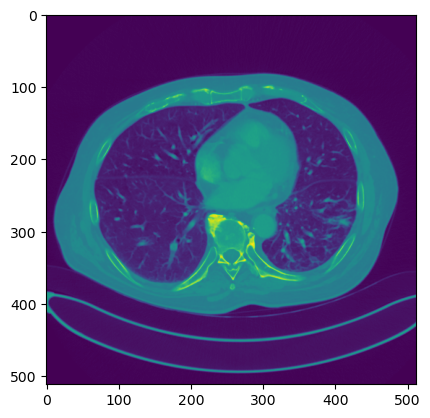

In [240]:
image = pydicom.dcmread(os.path.join(dataset_dir, 'data', 'converted_images', 'train_converted', 'pe_converted', '0e79a433e660.dcm'))
im = image.pixel_array.astype('float32')
scale = (np.maximum(im, 0)/im.max())
plt.imshow(scale)

In [241]:
def get_image_names(path):
    names = []
    for root, dirname, filenames in os.walk(path):
        for filename in filenames:
            _, ext = os.path.splitext(filename)
            if ext in ['.dcm']:
                names.append(filename)
    return names

In [242]:
train_pe_names = get_image_names(os.path.join(dataset_dir, 'data', 'train', 'pe'))

train_no_pe_names = get_image_names(os.path.join(dataset_dir, 'data', 'train', 'no_pe'))

valid_pe_names = get_image_names(os.path.join(dataset_dir, 'data', 'valid', 'pe'))

valid_no_pe_names = get_image_names(os.path.join(dataset_dir, 'data', 'valid', 'no_pe'))

In [243]:
def convert_pe_train_images_jpg(name):
    path = os.path.join(dataset_dir, 'data', 'train', 'pe',) + '\\' + name
    im = pydicom.dcmread(path)
    im = im.pixel_array.astype(float)
    rescale_image = (np.maximum(im, 0)/im.max()) * 255
    final_image= np.uint8(rescale_image)
    final_image = Image.fromarray(final_image).convert('RGB')
    return final_image

In [244]:
for name in train_pe_names:
    image = convert_pe_train_images_jpg(name)
    image.save(os.path.join(dataset_dir,'train_final', 'pe')+ '\\' + name + '.jpg')

In [245]:
def convert_no_pe_train_images_jpg(name):
    path = os.path.join(dataset_dir, 'data', 'train', 'no_pe',) + '\\' + name
    im = pydicom.dcmread(path)
    im = im.pixel_array.astype(float)
    rescale_image = (np.maximum(im, 0)/im.max()) * 255
    final_image= np.uint8(rescale_image)
    final_image = Image.fromarray(final_image).convert('RGB')
    return final_image

In [246]:
for name in train_no_pe_names:
    image = convert_no_pe_train_images_jpg(name)
    image.save(os.path.join(dataset_dir, 'train_final', 'no_pe')+ '\\' + name + '.jpg')

In [247]:
def convert_pe_valid_images_jpg(name):
    path = os.path.join(dataset_dir, 'data', 'valid', 'pe',) + '\\' + name
    im = pydicom.dcmread(path)
    im = im.pixel_array.astype(float)
    rescale_image = (np.maximum(im, 0)/im.max()) * 255
    final_image= np.uint8(rescale_image)
    final_image = Image.fromarray(final_image).convert('RGB')
    return final_image

In [248]:
for name in valid_pe_names:
    image = convert_pe_valid_images_jpg(name)
    image.save(os.path.join(dataset_dir, 'valid_final', 'pe')+ '\\' + name + '.jpg')

In [249]:
def convert_no_pe_valid_images_jpg(name):
    path = os.path.join(dataset_dir, 'data', 'valid', 'no_pe',) + '\\' + name
    im = pydicom.dcmread(path)
    im = im.pixel_array.astype(float)
    rescale_image = (np.maximum(im, 0)/im.max()) * 255
    final_image= np.uint8(rescale_image)
    final_image = Image.fromarray(final_image).convert('RGB')
    return final_image

In [250]:
for name in valid_no_pe_names:
    image = convert_no_pe_valid_images_jpg(name)
    image.save(os.path.join(dataset_dir, 'valid_final', 'no_pe')+ '\\' + name + '.jpg')

In [251]:
# Load Data
dataset_train = tf.keras.utils.image_dataset_from_directory(os.path.join(dataset_dir, 'train_final'))

Found 3500 files belonging to 2 classes.


In [252]:
dataset_valid = tf.keras.utils.image_dataset_from_directory(os.path.join(dataset_dir, 'valid_final'))

Found 1000 files belonging to 2 classes.


In [253]:
iterator = dataset_train.as_numpy_iterator()
batch = iterator.next()
batch[1]

# 1 - pe
# 0 - no pe

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0])

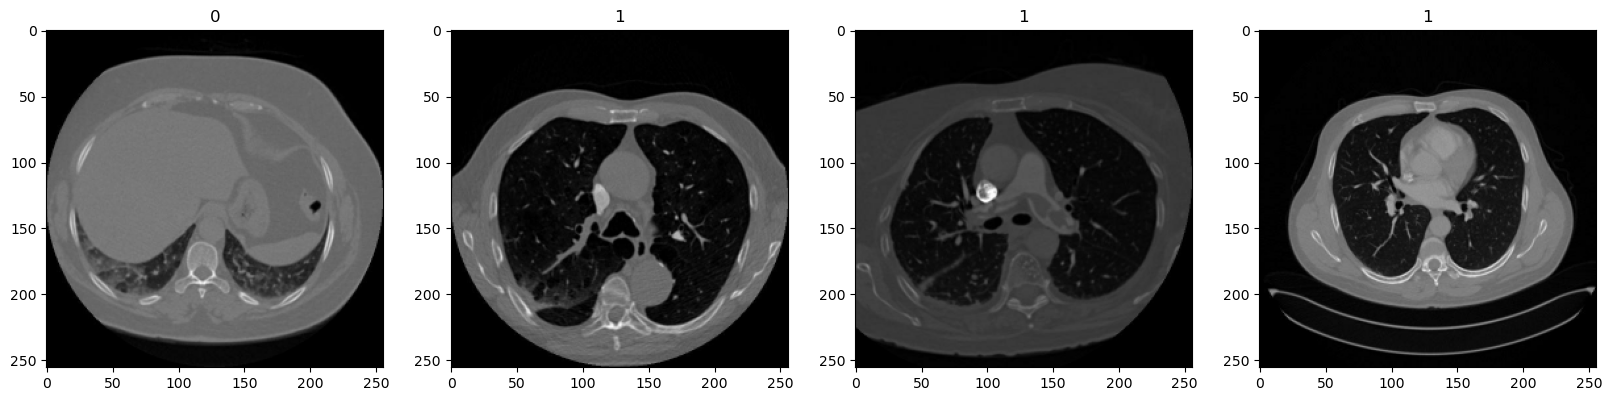

In [254]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [255]:
iterator_v = dataset_valid.as_numpy_iterator()
batch_v = iterator_v.next()
batch_v[1]

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0])

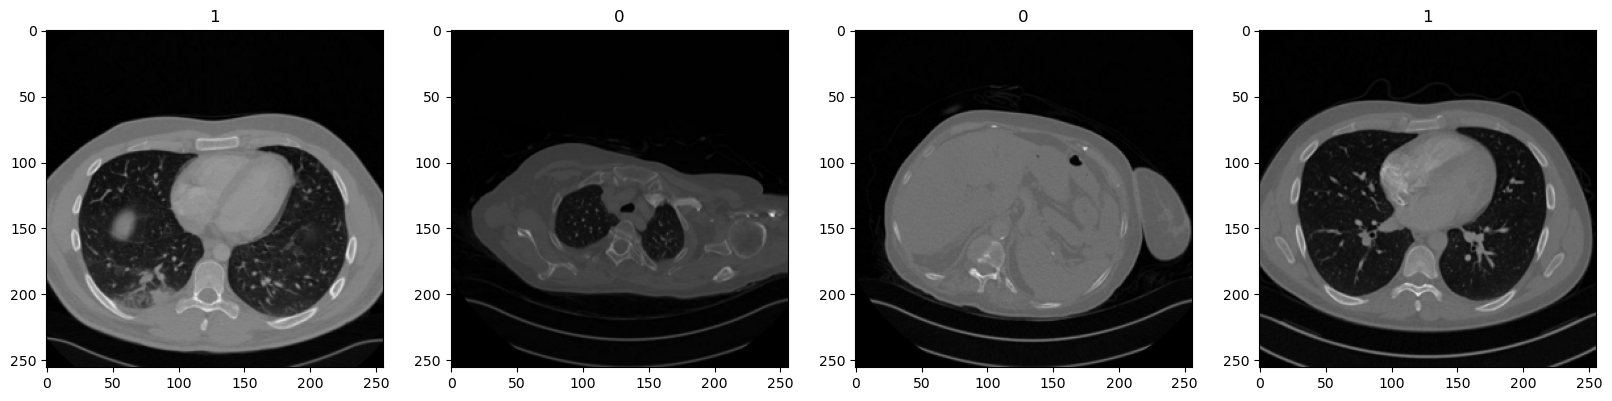

In [256]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch_v[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch_v[1][idx])

In [257]:
# Preprocessing - Rescaling
dataset_train = dataset_train.map(lambda x,y: (x/255, y))
dataset_valid = dataset_valid.map(lambda x,y: (x/255, y))

In [258]:
# Model
model = Sequential()

In [259]:
# Layers
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [260]:
model.compile(optimizer =SGD(learning_rate=0.0005), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [261]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 57600)            

In [262]:
hist = model.fit(dataset_train, 
                           validation_data=dataset_valid,
                           epochs = 25,
                           verbose = 1)

Epoch 1/25
110/110 [==============================] - 10s 80ms/step - loss: 0.6903 - accuracy: 0.5923 - val_loss: 0.6868 - val_accuracy: 0.6250
Epoch 2/25
110/110 [==============================] - 9s 79ms/step - loss: 0.6857 - accuracy: 0.6649 - val_loss: 0.6827 - val_accuracy: 0.7330
Epoch 3/25
110/110 [==============================] - 9s 79ms/step - loss: 0.6810 - accuracy: 0.7106 - val_loss: 0.6786 - val_accuracy: 0.7980
Epoch 4/25
110/110 [==============================] - 9s 79ms/step - loss: 0.6760 - accuracy: 0.7291 - val_loss: 0.6741 - val_accuracy: 0.8170
Epoch 5/25
110/110 [==============================] - 9s 80ms/step - loss: 0.6704 - accuracy: 0.7446 - val_loss: 0.6687 - val_accuracy: 0.7780
Epoch 6/25
110/110 [==============================] - 9s 79ms/step - loss: 0.6638 - accuracy: 0.7397 - val_loss: 0.6623 - val_accuracy: 0.7650
Epoch 7/25
110/110 [==============================] - 10s 87ms/step - loss: 0.6559 - accuracy: 0.7423 - val_loss: 0.6545 - val_accuracy: 0.76